## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
from pylab import rcParams
from scipy import spatial
plt.style.use('ggplot')

#### Load file

In [2]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
#PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.50d.txt'
PATH = 'glove.6B.50d.txt'
emb_dim = 50

In [3]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    #BEFORE pass
    dict = {}
    '''My approach
    with open(path, 'r', encoding="utf8") as f:
        for i, line in enumerate(f):
            lineSplitted = line.split()
            dict[lineSplitted[0]] = lineSplitted[2:]
    '''
    with open(path, 'r', encoding="utf8") as f:
        for line in f:
            lineSplitted = line.split()
            word = lineSplitted[0]
            vector = np.asarray(lineSplitted[1:], "float32")
            dict[word] = vector
            
    return dict    

In [4]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [5]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [6]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [7]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [8]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):
    #BEFORE pass
    '''My approach
    pcaOrTsne = func(n_components=2, random_state=0)
    words =  list(embeddings_dict.keys())
    vectors = np.array([embeddings_dict[word] for word in words])
    Y = pcaOrTsne.fit_transform(vectors[:1000])
    plt.scatter(Y[:, 0], Y[:, 1])

    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    plt.show()
    '''
    funcBeingUsed = str(func.__class__.__name__)
    if type(func).__name__ == 'ABCMeta':
        funcBeingUsed = 'PCA'
    else:
        funcBeingUsed = 'TSNE'
    
    word_matrix = np.random.randn(len(words2show),emb_dim)
    i = 0
    for word in words2show:
        word_matrix[i] = embeddings_dict[word]
        i +=1
    rcParams['figure.figsize'] = 15, 10
    pcaOrTsne = func(n_components=2)
    viz_data = pcaOrTsne.fit_transform(word_matrix)
    plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))
    for label,x,y in zip(words2show,viz_data[:,0],viz_data[:,1]):
        plt.annotate(
            label,
            xy=(x,y),
            xytext=(-14, 14),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )
    plt.xlabel(funcBeingUsed+' Component 1 ')
    plt.ylabel(funcBeingUsed+' Component 2')
    plt.title(funcBeingUsed+' representation for Word Embedding')
    plt.xlim(-10,10)
    plt.ylim(-5,6)

In [9]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', 
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


C:\Users\os190\AppData\Local\Temp\ipykernel_2448\905966862.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))


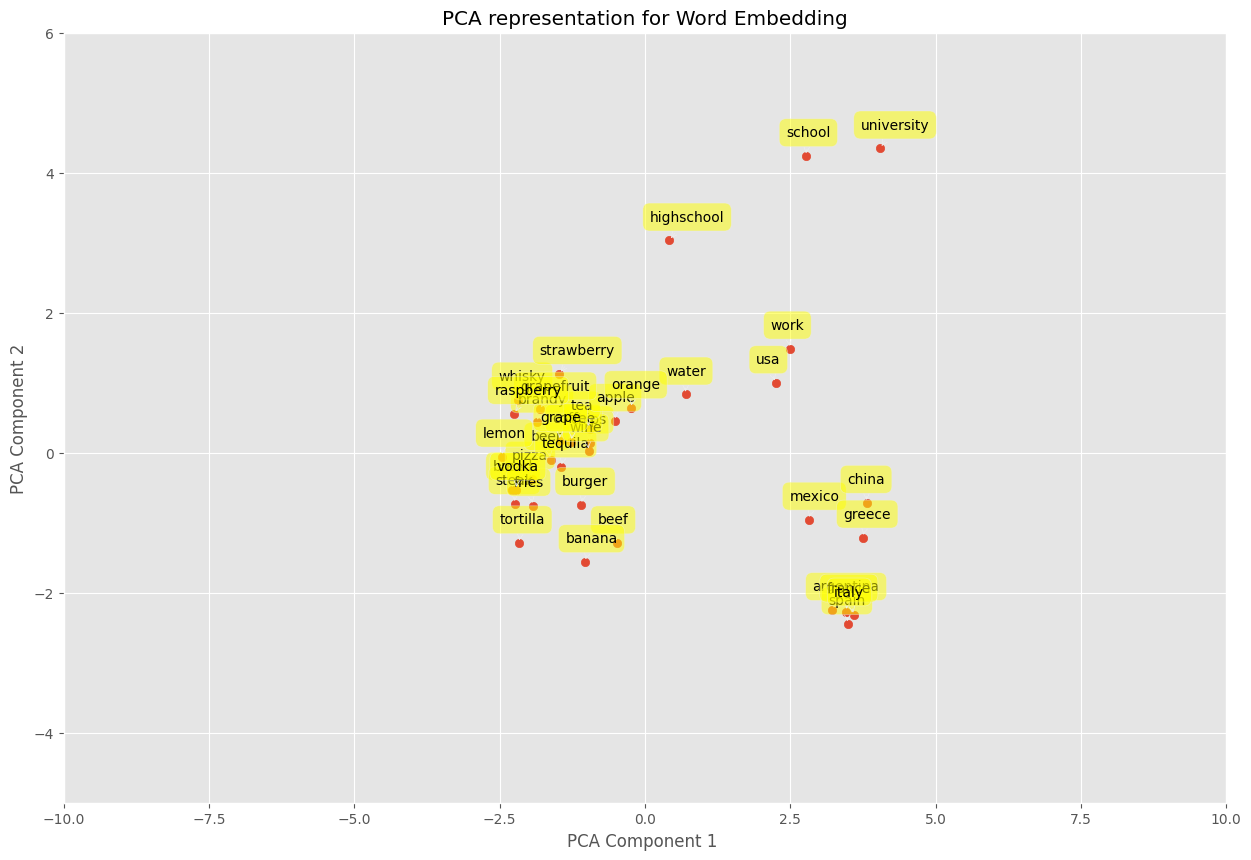

In [10]:
# 
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

C:\Users\os190\AppData\Local\Temp\ipykernel_2448\905966862.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))


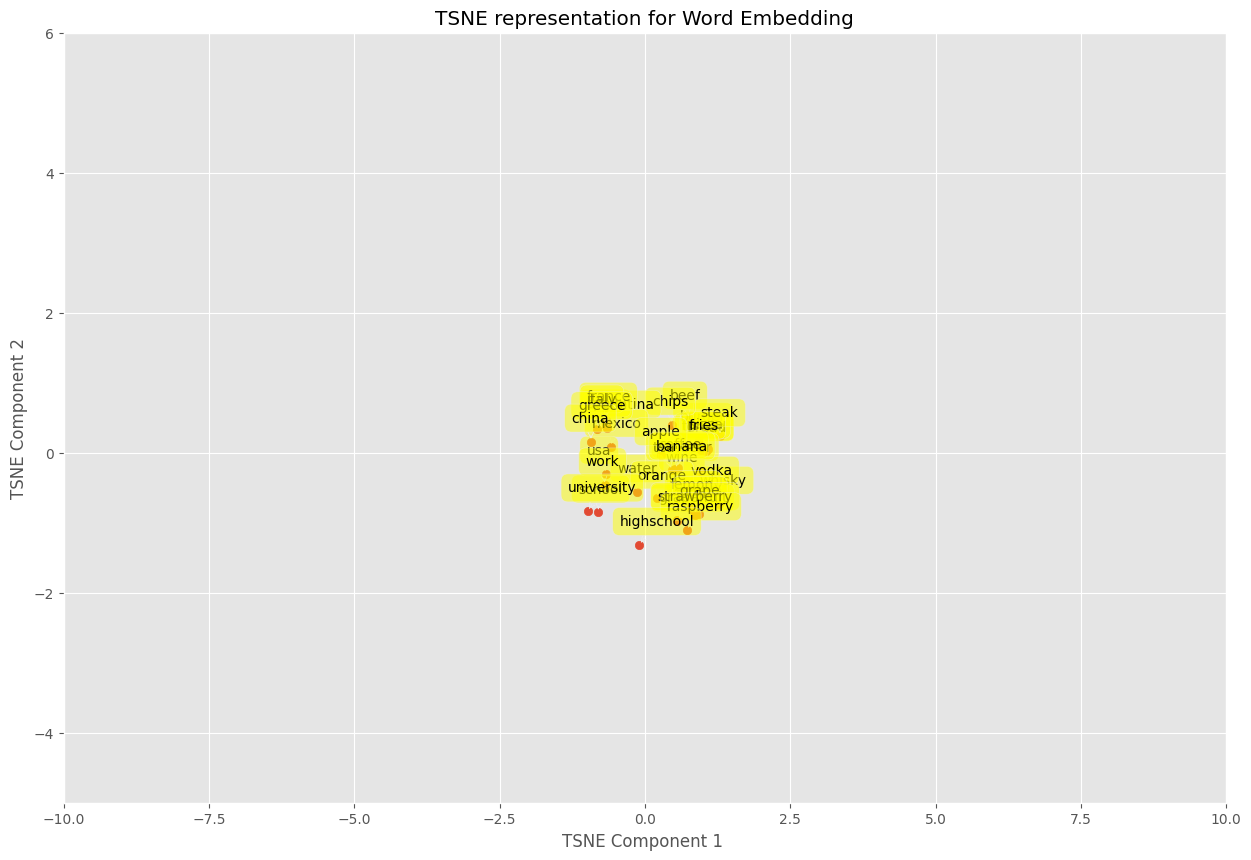

In [11]:
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

In [12]:
def cos_sim(u,v):
    """
    u: vector of 1st word
    v: vector of 2nd Word
    """
    numerator_ = u.dot(v)
    denominator_= np.sqrt(np.sum(np.square(u))) * np.sqrt(np.sum(np.square(v)))
    return numerator_/denominator_

In [13]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    #BEFORE pass
    """
    """
    word_list = embeddings_dict.keys()
    max_sim = -1000
    #Make Sure they are lower
    word1,word2,word3 = word1.lower(),word2.lower(),word3.lower()
    diff_vec = embeddings_dict[word3] - (embeddings_dict[word1]-embeddings_dict[word2]) #word3 - (word1 - word2)
    for word in word_list:
        vec = embeddings_dict[word]
        sim_ = cos_sim(u=diff_vec,v=vec)
        if sim_ > max_sim:
            max_sim = sim_
            word_selected =  word
            
    return word_selected

In [14]:
analogy('man', 'king', 'woman', embeddings_dict)

'king'

In [15]:
# most similar
def find_most_similar(words, embeddings_dict, top_n=10):
    #BEFORE pass
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embeddings_dict[words]))[:top_n]

In [16]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [17]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w}')

1 ---> mexico
2 ---> venezuela
3 ---> peru
4 ---> mexican
5 ---> chile
6 ---> colombia
7 ---> puerto
8 ---> rico
9 ---> guatemala
10 ---> panama


https://www.kaggle.com/code/ankitswarnkar/word-embedding-using-glove-vector

https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db